In [1]:
import sys
sys.path.append('..')
sys.path.append('../..')

In [2]:
import os
from os import path
import torch
from torch.utils.data import DataLoader
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

In [3]:
from Pytorch.utils import Denormalize_tensor, Show_figure_with_bbox
from Pytorch.Datasets.ROIDataset import ROI_DATASET
from Pytorch.Models.ROIClassifier import M_ROI_CLASSIFIER

In [4]:
exp_name = "RN50-SGD-ROIClassification-Benedettini-DA"
epochs = 120
batch_size = 10
num_batch_train = 200
num_batch_val = 80

In [5]:
parameters_path = path.join("parameters", exp_name)
plots_path = path.join("plots", exp_name)

In [6]:
DSET_training = ROI_DATASET(
    root_dirpath = '../../../Datasets/Points Of Interest Recognition/Monastero dei Benedettini/',
    images_dirpath = '../../../Datasets/Points Of Interest Recognition/Monastero dei Benedettini/',
    annotations_path = '../../../Datasets/Points Of Interest Recognition/Monastero dei Benedettini/train_dataset.json',
    image_id_key="path",
    category_id_key="class_id",
    augmentation=True,
    batch_size=batch_size,
    num_batch=num_batch_train
)

In [7]:
DSET_validation = ROI_DATASET(
    root_dirpath = '../../../Datasets/Points Of Interest Recognition/Monastero dei Benedettini/',
    images_dirpath = '../../../Datasets/Points Of Interest Recognition/Monastero dei Benedettini/',
    annotations_path = '../../../Datasets/Points Of Interest Recognition/Monastero dei Benedettini/val_dataset.json',
    image_id_key="path",
    category_id_key="class_id",
    augmentation=False,
    batch_size=batch_size,
    num_batch=num_batch_val
)

{'id': 34, 'name': '8.9_Pozzo'}

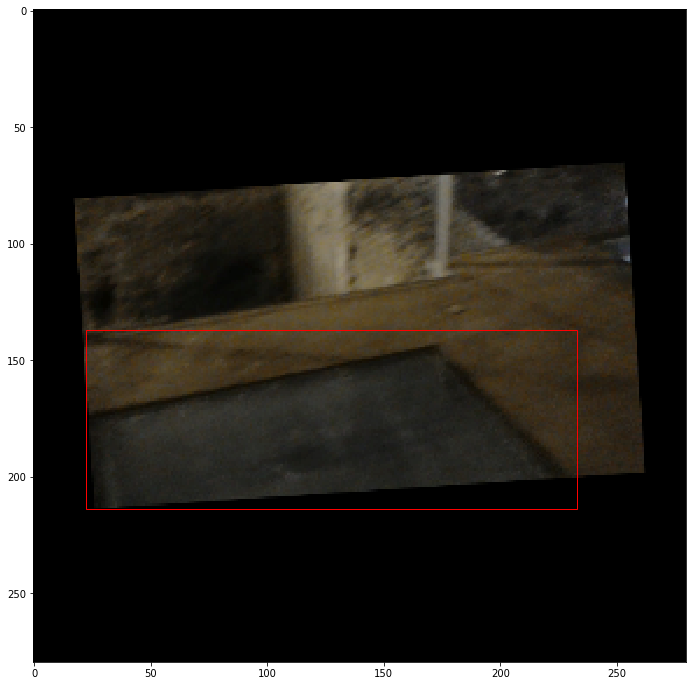

In [8]:
(T_img, T_bbox), class_idx = DSET_training[0]
denormalize_func = Denormalize_tensor(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
T_normal_img = denormalize_func(T_img)
Show_figure_with_bbox(transforms.ToPILImage()(T_normal_img), (T_img.shape[1:3]), T_bbox.numpy())
DSET_training.Get_class_idx_description(class_idx)

{'id': 13, 'name': '6.4_PavimentoRestaurato'}

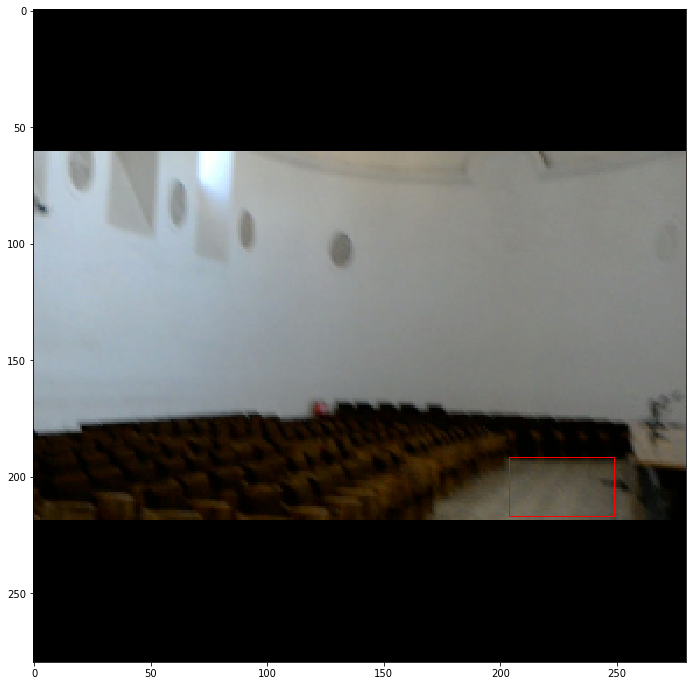

In [9]:
(T_img, T_bbox), class_idx = DSET_validation[0]
denormalize_func = Denormalize_tensor(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
T_normal_img = denormalize_func(T_img)
Show_figure_with_bbox(transforms.ToPILImage()(T_normal_img), (T_img.shape[1:3]), T_bbox.numpy())
DSET_training.Get_class_idx_description(class_idx)

In [10]:
DL_training = DataLoader(DSET_training, batch_size=batch_size, shuffle=False)
DL_validation = DataLoader(DSET_validation, batch_size=batch_size, shuffle=False)

In [11]:
M_roi_classifier = M_ROI_CLASSIFIER(num_classes=DSET_training.Get_num_classes())
M_roi_classifier = M_roi_classifier.to('cuda')

In [12]:
def prepare_batch_fn(batch, gt):
    gt = gt.long()
    return batch, gt

In [13]:
from torchtrainer.trainer import Trainer, Mode
from torchtrainer.callbacks.calculateaccuracycallback import CalculateTopNAccuracyCallback
from torchtrainer.callbacks.calculatelosscallback import CalculateLossCallback
from torchtrainer.callbacks.plotcallback import PlotCallback
from torchtrainer.callbacks.saveparameterscallback import SaveParametersCallback
from torchtrainer.callbacks.settqdmbardescription import SetTQDMBarDescription
from torchtrainer.callbacks.lrbatchschedulercallback import LRBatchSchedulerCallBack

In [14]:
optimizer = torch.optim.SGD(M_roi_classifier.parameters(), lr = 0.005, momentum = 0.2)
criterion = torch.nn.CrossEntropyLoss()

In [17]:
trainer = Trainer(
    device = 'cuda',
    modes = [Mode.TRAIN, Mode.EVALUATE],
    model = M_roi_classifier,
    data_loaders = {Mode.TRAIN : DL_training, Mode.EVALUATE : DL_validation},
    epochs = epochs,
    starting_epoch = 0,
    optimizer = optimizer,
    criterion = criterion,
    prepare_batch_fn = prepare_batch_fn,
    callbacks = [
        CalculateLossCallback(key='Loss'),
        CalculateTopNAccuracyCallback(keys=('Top-1 accuracy',), topk=(1,)),
        PlotCallback(plots_path, labels_map={Mode.TRAIN:"Train", Mode.EVALUATE:"Val"}, columns=['Loss', 'Top-1 accuracy']),
        SetTQDMBarDescription(keys=['Loss', 'Top-1 accuracy']),
        SaveParametersCallback(parameters_path),
    ]
)

In [ ]:
trainer.start()

Epoch 0


Loss = 1.4528 Top-1 accuracy = 63.8750 : 100%|██████████| 80/80 [02:32<00:00,  1.91s/it]

Epoch 1



Loss = 1.4111 Top-1 accuracy = 70.0000 : 100%|██████████| 80/80 [02:32<00:00,  1.91s/it]

Epoch 2



Loss = 0.2263 Top-1 accuracy = 93.1579 :  48%|████▊     | 95/200 [09:55<10:58,  6.27s/it]

In [13]:
from torch_lr_finder import LRFinder

  pip install torch-lr-finder -v --global-option="amp"


In [14]:
criterion = torch.nn.CrossEntropyLoss()


Learning rate search finished. See the graph with {finder_name}.plot()


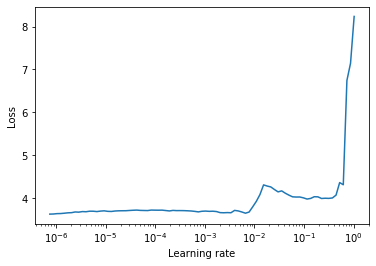

In [15]:
optimizer = torch.optim.SGD(M_roi_classifier.parameters(), lr=1e-7, momentum=0.0)
lr_finder = LRFinder(M_roi_classifier, optimizer, criterion, device="cuda")
lr_finder.range_test(DL_training, end_lr=2, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


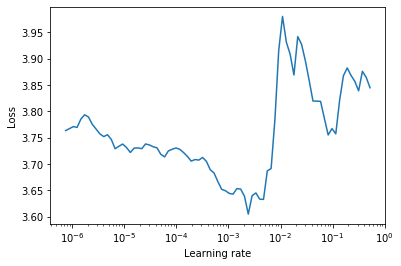

In [16]:
optimizer = torch.optim.SGD(M_roi_classifier.parameters(), lr=1e-7, momentum=0.2)
lr_finder = LRFinder(M_roi_classifier, optimizer, criterion, device="cuda")
lr_finder.range_test(DL_training, end_lr=2, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


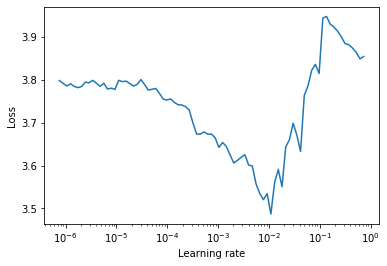

In [17]:
optimizer = torch.optim.SGD(M_roi_classifier.parameters(), lr=1e-7, momentum=0.6)
lr_finder = LRFinder(M_roi_classifier, optimizer, criterion, device="cuda")
lr_finder.range_test(DL_training, end_lr=2, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state